## Cats vs Dogs full

In [2]:
# key file upload
from google.colab import files
up = files.upload()

Saving kaggle.json to kaggle (1).json


In [3]:
import os, json

with open('kaggle.json') as f:
    kaggle = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle['username']
os.environ['KAGGLE_KEY'] = kaggle['key']

In [4]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 96% 760M/788M [00:06<00:00, 244MB/s]
100% 788M/788M [00:06<00:00, 130MB/s]


In [5]:
!unzip microsoft-catsvsdogs-dataset.zip > filenames

In [6]:
cat_dir = 'PetImages/Cat'
os.unlink(f'{cat_dir}/Thumbs.db')       # 압축 해제시 생성된 임시파일 삭제
cat_list = os.listdir(cat_dir)
len(cat_list)

12500

In [7]:
dog_dir = 'PetImages/Dog'
os.unlink(f'{dog_dir}/Thumbs.db')       # 압축 해제시 생성된 임시파일 삭제
dog_list = os.listdir(dog_dir)
len(dog_list)

12500

- 이미지 파일 에러 찾기

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
from PIL import Image
from glob import glob

In [10]:
cat_list[:5]

['11867.jpg', '9234.jpg', '2025.jpg', '11224.jpg', '7258.jpg']

In [11]:
for fname in cat_list:
    try:
        img = Image.open(f'PetImages/Cat/{fname}')
    except:
        print(fname)

666.jpg


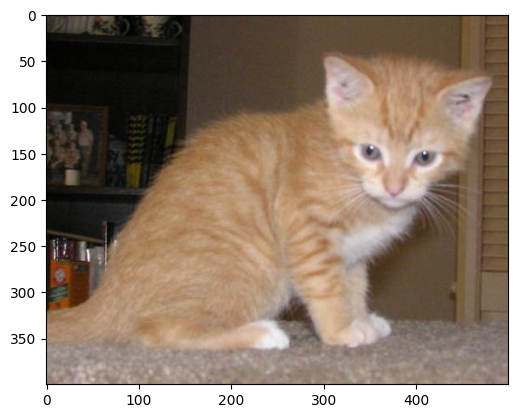

In [12]:
import matplotlib.pyplot as plt
plt.imshow(img);

In [13]:
for fname in glob(f'{dog_dir}/*'):
    try:
        img = Image.open(fname)
    except:
        print(fname)

PetImages/Dog/11702.jpg


- train data: 0.jpg ~ 7999.jpg (8,000개)
- valid data: 8000.jpg ~ 9999.jpg (2,000개)
- test data: 10000.jpg ~ 12499.jpg (2,500개)

In [14]:
!cp PetImages/Cat/9999.jpg PetImages/Cat/666.jpg
!cp PetImages/Dog/9999.jpg PetImages/Dog/11702.jpg

In [15]:
!mkdir PetImages/test PetImages/valid
!mkdir PetImages/test/cats PetImages/test/dogs
!mkdir PetImages/valid/cats PetImages/valid/dogs

In [16]:
!mv PetImages/Cat/8???.* PetImages/valid/cats
!mv PetImages/Dog/8???.* PetImages/valid/dogs
!mv PetImages/Cat/9???.* PetImages/valid/cats
!mv PetImages/Dog/9???.* PetImages/valid/dogs

In [17]:
!mv PetImages/Cat/1????.* PetImages/test/cats
!mv PetImages/Dog/1????.* PetImages/test/dogs

In [18]:
!mkdir PetImages/train
!mv PetImages/Cat PetImages/train/cats
!mv PetImages/Dog PetImages/train/dogs

- 모델 구성

In [19]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
model = Sequential([
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),  # 이미지를 150x150의 크기로 변환해주는 무언가가 필요함
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [21]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model_path = 'best-cats-and-dogs.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

- 파일에서 이미지 데이터를 읽어서 학습

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)

In [23]:
train_dir = 'PetImages/train'       # 8000 + 8000
test_dir = 'PetImages/test'         # 2500 + 2500
valid_dir = 'PetImages/valid'       # 2000 + 2000

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    test_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 16000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


- 모델 학습

In [25]:
hist = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    steps_per_epoch=800,    # batch_size(20) x steps_per_epoch(800) = 16000, 트레인 데이터가 16,000개
    validation_steps=200,   # batch_size(20) x validation_steps(200) = 4000, 검증 데이터가 4,000개
    callbacks=[mc, es]
)

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5969
Epoch 1: val_loss improved from inf to 0.60104, saving model to best-cats-and-dogs.h5
800/800 [==============================] - 52s 49ms/step - loss: 0.6861 - accuracy: 0.5969 - val_loss: 0.6010 - val_accuracy: 0.6982
Epoch 2/100
799/800 [============================>.] - ETA: 0s - loss: 0.5638 - accuracy: 0.7147
Epoch 2: val_loss improved from 0.60104 to 0.47466, saving model to best-cats-and-dogs.h5
800/800 [==============================] - 39s 48ms/step - loss: 0.5640 - accuracy: 0.7147 - val_loss: 0.4747 - val_accuracy: 0.7735
Epoch 3/100
799/800 [============================>.] - ETA: 0s - loss: 0.4641 - accuracy: 0.7825
Epoch 3: val_loss did not improve from 0.47466
800/800 [==============================] - 38s 48ms/step - loss: 0.4641 - accuracy: 0.7824 - val_loss: 0.4870 - val_accuracy: 0.7670
Epoch 4/100
800/800 [==============================] - ETA: 0s - loss: 0.3951 - accurac

In [26]:
best_model = load_model(model_path)
best_model.evaluate(test_generator)

250/250 [==============================] - 9s 37ms/step - loss: 0.3909 - accuracy: 0.8204


[0.3908804655075073, 0.8203999996185303]

In [28]:
from google.colab import files

up = files.upload()

Saving cat01.jpg to cat01.jpg
Saving cat02.jpg to cat02.jpg
Saving cat03.jpg to cat03.jpg
Saving dog01.jpg to dog01.jpg
Saving dog02.jpg to dog02.jpg
Saving dog03.jpg to dog03.jpg


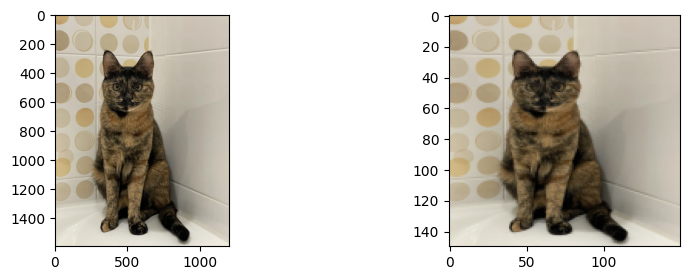

In [29]:
import cv2

img = cv2.imread('cat02.jpg')[:,:,::-1]
img2 = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [30]:
best_model.predict(img2.reshape(-1, 150, 150, 3))

1/1 [==============================] - 0s 194ms/step


array([[1.3859206e-26]], dtype=float32)

In [31]:
for fname in up.keys():
  img = cv2.imread(fname)[:,:,::-1]
  img2 = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_AREA)
  classes = best_model.predict(img2.reshape(-1, 150, 150, 3), verbose=0)
  print(f"{classes[0, 0]:.4f} {fname} is a {'dog' if classes[0, 0] > 0.5 else 'cat'}")

0.0000 cat01.jpg is a cat
0.0000 cat02.jpg is a cat
0.0000 cat03.jpg is a cat
1.0000 dog01.jpg is a dog
1.0000 dog02.jpg is a dog
1.0000 dog03.jpg is a dog
